# Projet de Machine Learning - Spotify

In [90]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.svm import SVR
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.preprocessing import scale
from sklearn.linear_model import lasso_path
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier 
from sklearn.neural_network import MLPRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor

## Lecture du jeu de données

In [5]:
spotify_unrefined = pd.read_csv("spotify-extr.txt", sep = " ")

In [6]:
spotify_unrefined.head()

valence  year  acousticness  danceability  duration  energy  \
161704    0.647  1975        0.4490         0.376    298840   0.827   
168077    0.150  2008        0.8990         0.508    236800   0.169   
35922     0.423  2007        0.0185         0.470    301093   0.878   
135823    0.302  1995        0.0384         0.176    142200   0.980   
165395    0.828  1994        0.5310         0.705    187800   0.625   

        instrumentalness key  liveness  loudness  mode  popularity  \
161704          0.007880   B     0.466    -7.604     1          25   
168077          0.000011  Ab     0.136   -11.332     1          42   
35922           0.083900   B     0.276    -5.576     0          65   
135823          0.552000   B     0.237    -3.154     1          36   
165395          0.000008   G     0.348   -11.963     0          38   

        speechiness    tempo pop.class  
161704       0.3990  170.475         C  
168077       0.0553  107.477         B  
35922        0.0377  150.093         A  
135823       0.0721  172.566         C  
165395       0.0639   97.831         C

In [7]:
spotify_unrefined["key"] = pd.Categorical(spotify_unrefined["key"], ordered = False)
spotify_unrefined["mode"] = pd.Categorical(spotify_unrefined["mode"], ordered = False)
spotify_unrefined["pop.class"] = pd.Categorical(spotify_unrefined["pop.class"], ordered = True)

In [8]:
spotify_unrefined.describe()

valence          year  acousticness  danceability      duration  \
count  10000.000000  10000.000000  10000.000000  10000.000000  1.000000e+04   
mean       0.532815   1977.026200      0.495719      0.540029  2.272151e+05   
std        0.262431     26.000068      0.377681      0.176193  1.124568e+05   
min        0.000000   1921.000000      0.000000      0.000000  5.991000e+03   
25%        0.324000   1956.000000      0.092675      0.417000  1.690670e+05   
50%        0.543000   1978.000000      0.504000      0.550000  2.065295e+05   
75%        0.751000   1999.000000      0.889250      0.671000  2.597330e+05   
max        0.993000   2020.000000      0.996000      0.988000  2.703227e+06   

             energy  instrumentalness      liveness      loudness  \
count  10000.000000      10000.000000  10000.000000  10000.000000   
mean       0.487500          0.164947      0.204063    -11.437683   
std        0.267729          0.313327      0.173221      5.787993   
min        0.000000          0.000000      0.000000    -60.000000   
25%        0.262000          0.000000      0.097800    -14.557000   
50%        0.476000          0.000174      0.135000    -10.552500   
75%        0.708000          0.087100      0.256000     -7.115500   
max        1.000000          1.000000      0.991000      1.342000   

         popularity   speechiness         tempo  
count  10000.000000  10000.000000  10000.000000  
mean      31.558100      0.101815    116.865750  
std       21.915904      0.168111     30.969039  
min        0.000000      0.000000      0.000000  
25%       11.000000      0.035000     93.564500  
50%       33.000000      0.045400    114.437500  
75%       48.250000      0.078600    135.470000  
max       93.000000      0.969000    214.419000

## Exploration

### Adaptation des données

In [9]:
spotify = spotify_unrefined.copy()

In [10]:
def scatter_matrix_display(variables_list):
    plt.figure()
    pd.plotting.scatter_matrix(spotify[variables_list], alpha = 0.2, figsize = (20, 20), diagonal = 'kde')
    plt.show()

In [11]:
def histogram_display(variable):
    plt.figure()
    spotify[variable].hist()
    plt.title("Histogram of the variable " + variable)
    plt.show()

In [12]:
def translated_log(x):
    return np.log(1 + x)

In [13]:
def variable_mapping(variable, function):
    histogram_display(variable)
    if function == np.log or function == translated_log:
        new_variable = "log_" + variable
    elif function == np.exp:
        new_variable = "exp_" + variable
    elif function == np.sqrt:
        new_variable = "sqrt_" + variable
    spotify[new_variable] = spotify[variable].map(lambda x: function(x))
    histogram_display(new_variable)
    del spotify[variable]

In [14]:
quantitativ_variables = ["valence", "year", "acousticness", "danceability", "duration", "energy",
                         "instrumentalness", "liveness", "loudness", "popularity", "speechiness", "tempo"]

<Figure size 432x288 with 0 Axes>

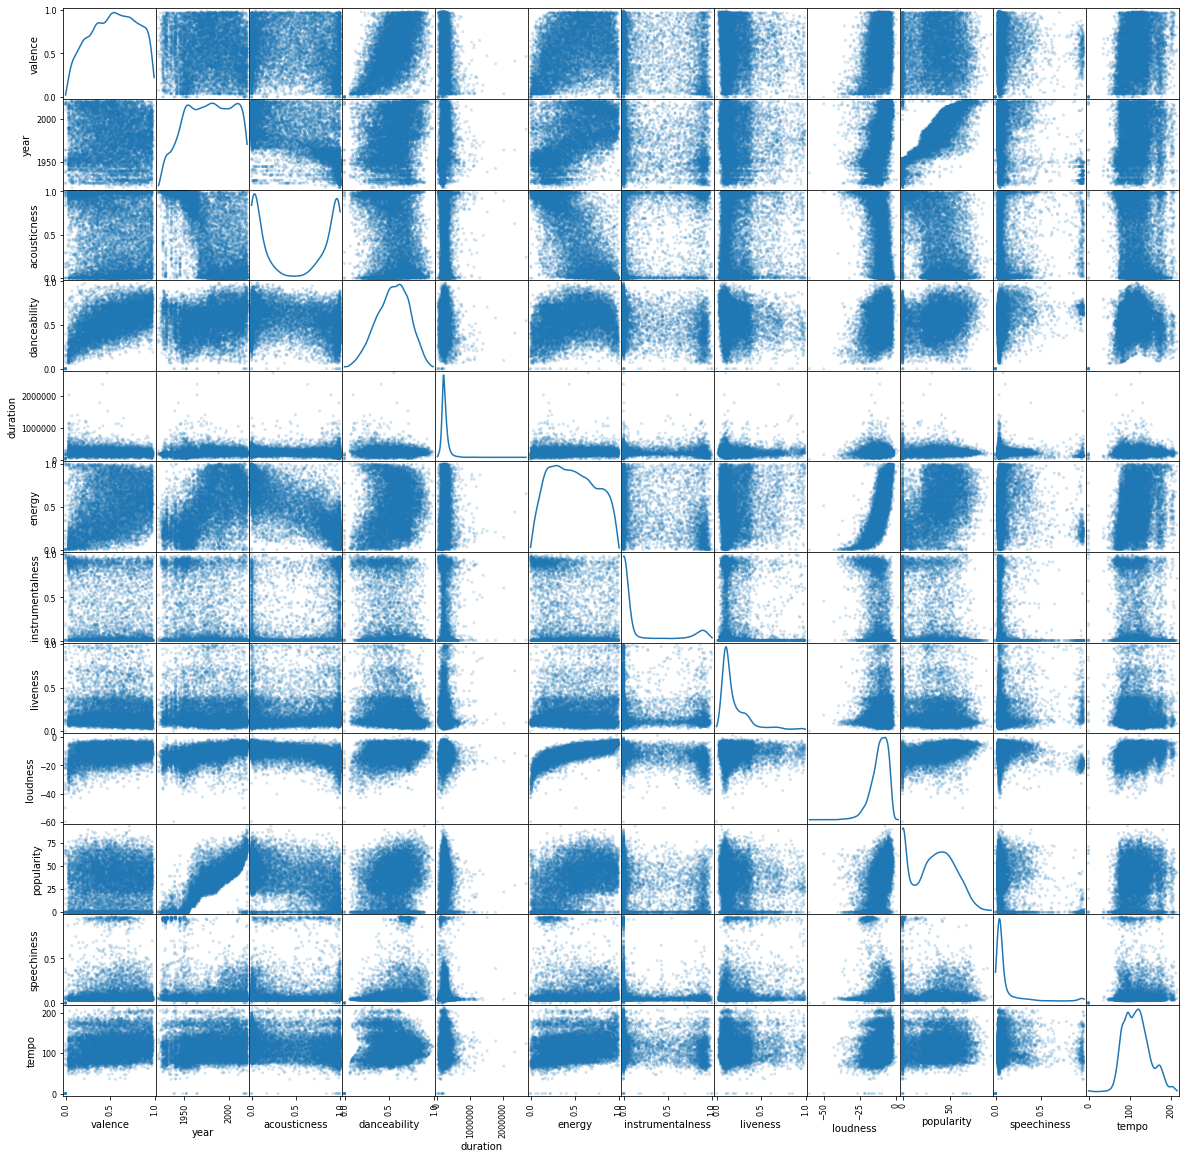

In [15]:
scatter_matrix_display(quantitativ_variables)

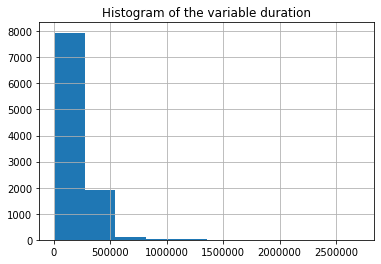

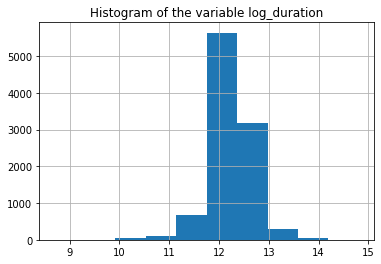

In [16]:
variable_mapping("duration", np.log)

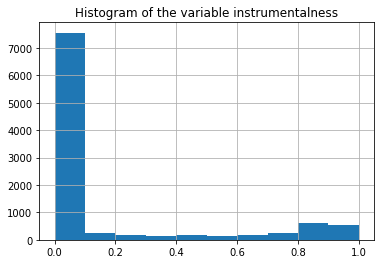

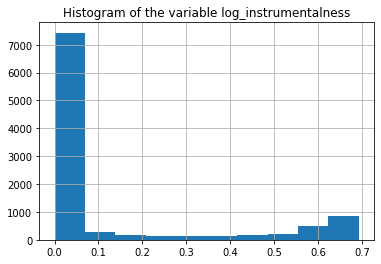

In [17]:
variable_mapping("instrumentalness", translated_log)

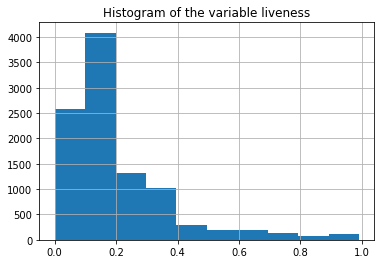

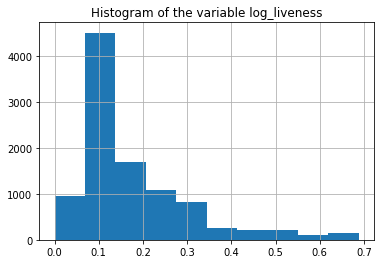

In [18]:
variable_mapping("liveness", translated_log)

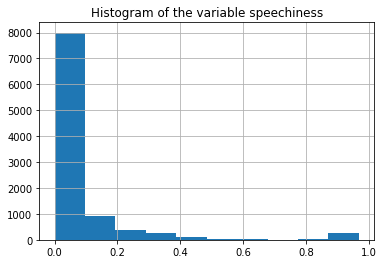

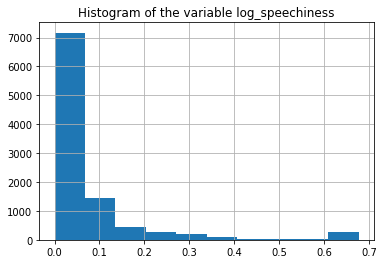

In [19]:
variable_mapping("speechiness", translated_log)

In [20]:
quantitativ_variables = ["valence", "year", "acousticness", "danceability", "energy", "loudness", "popularity",
                         "tempo", "log_duration", "log_instrumentalness", "log_liveness", "log_speechiness"]

<Figure size 432x288 with 0 Axes>

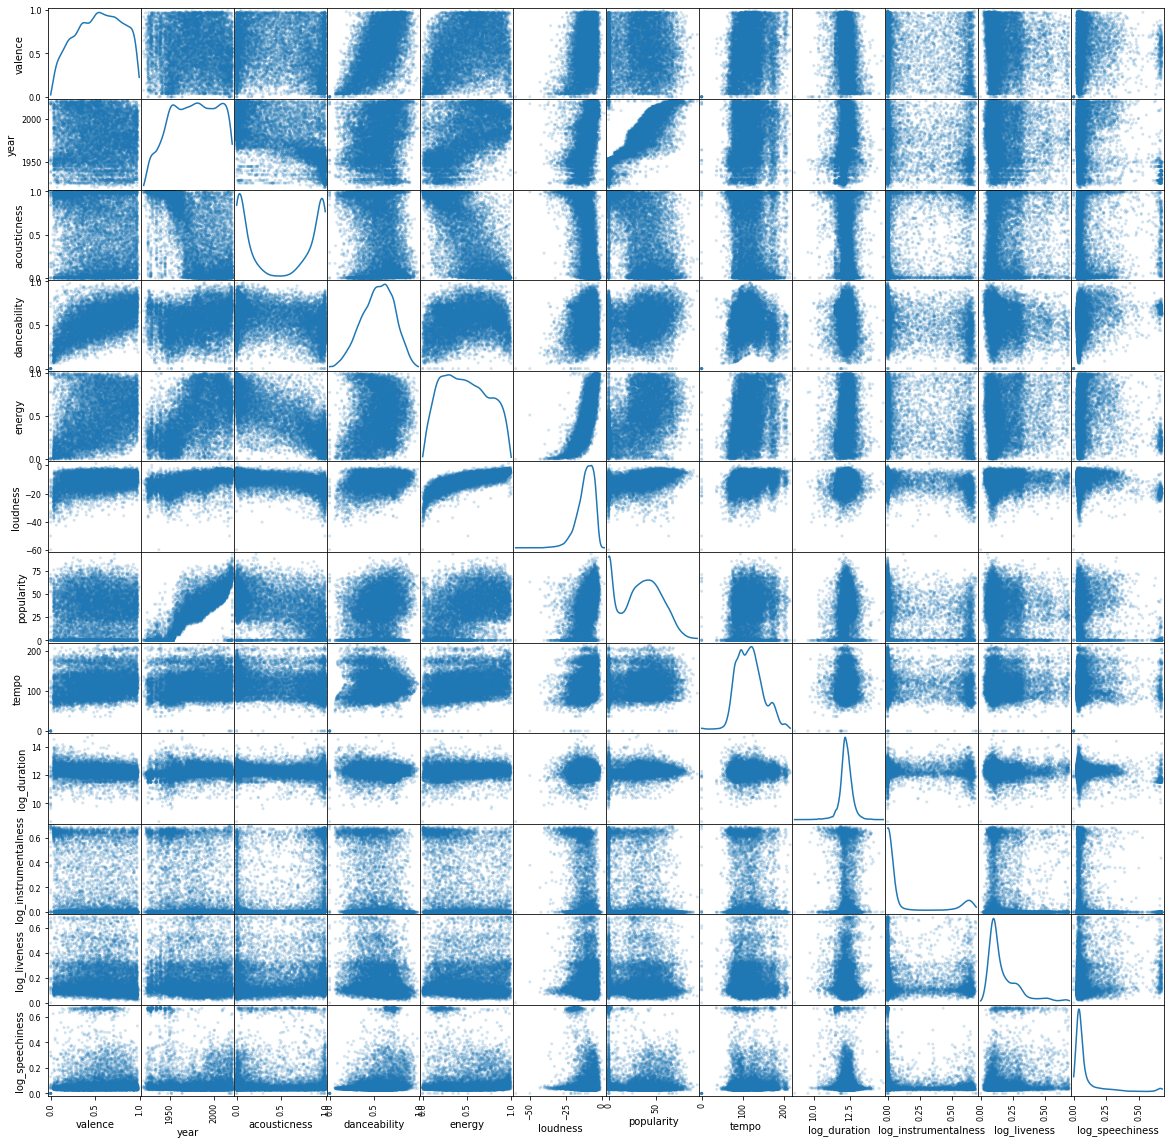

In [21]:
scatter_matrix_display(quantitativ_variables)

### Analyse en composantes principales

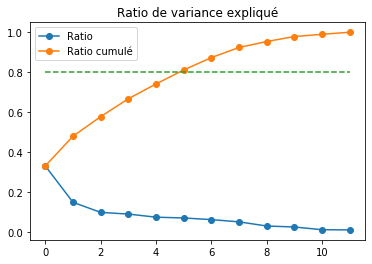

In [22]:
x = scale(spotify[quantitativ_variables])

pca = PCA()
c = pca.fit(x).transform(x)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure()
plt.plot(explained_variance_ratio, '-o', label = "Ratio")
plt.plot(np.cumsum(explained_variance_ratio), '-o', label = "Ratio cumulé")
plt.plot(0.8 * np.ones(explained_variance_ratio.shape[0]), '--')
plt.title("Ratio de variance expliqué")
plt.legend()
plt.show()

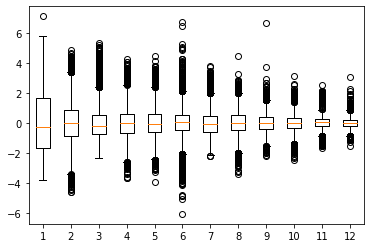

In [23]:
plt.figure()
plt.boxplot(c[: , : 20])
plt.show()

In [24]:
def individual_graph(axe_x, axe_y):
    pop_class = spotify["pop.class"].to_numpy()
    color = []
    for i in range(pop_class.shape[0]):
        if pop_class[i] == 'A': color += ['red']
        elif pop_class[i] == 'B': color += ['blue']
        elif pop_class[i] == 'C': color += ['green']
        elif pop_class[i] == 'D': color += ['yellow']
    plt.scatter(c[: , axe_x], c[: , axe_y], marker = 'x', c = color)
    plt.xlabel("Axe " + str(axe_x))
    plt.ylabel("Axe " + str(axe_y))

In [25]:
def stair_display(display_function):
    count = 1
    
    plt.figure(figsize = (25, 25))
    for a in range(0, 5):
        count += a
        for b in range(a + 1, 5):
            plt.subplot(4, 4, count)
            display_function(a, b)
            count += 1
    plt.show()

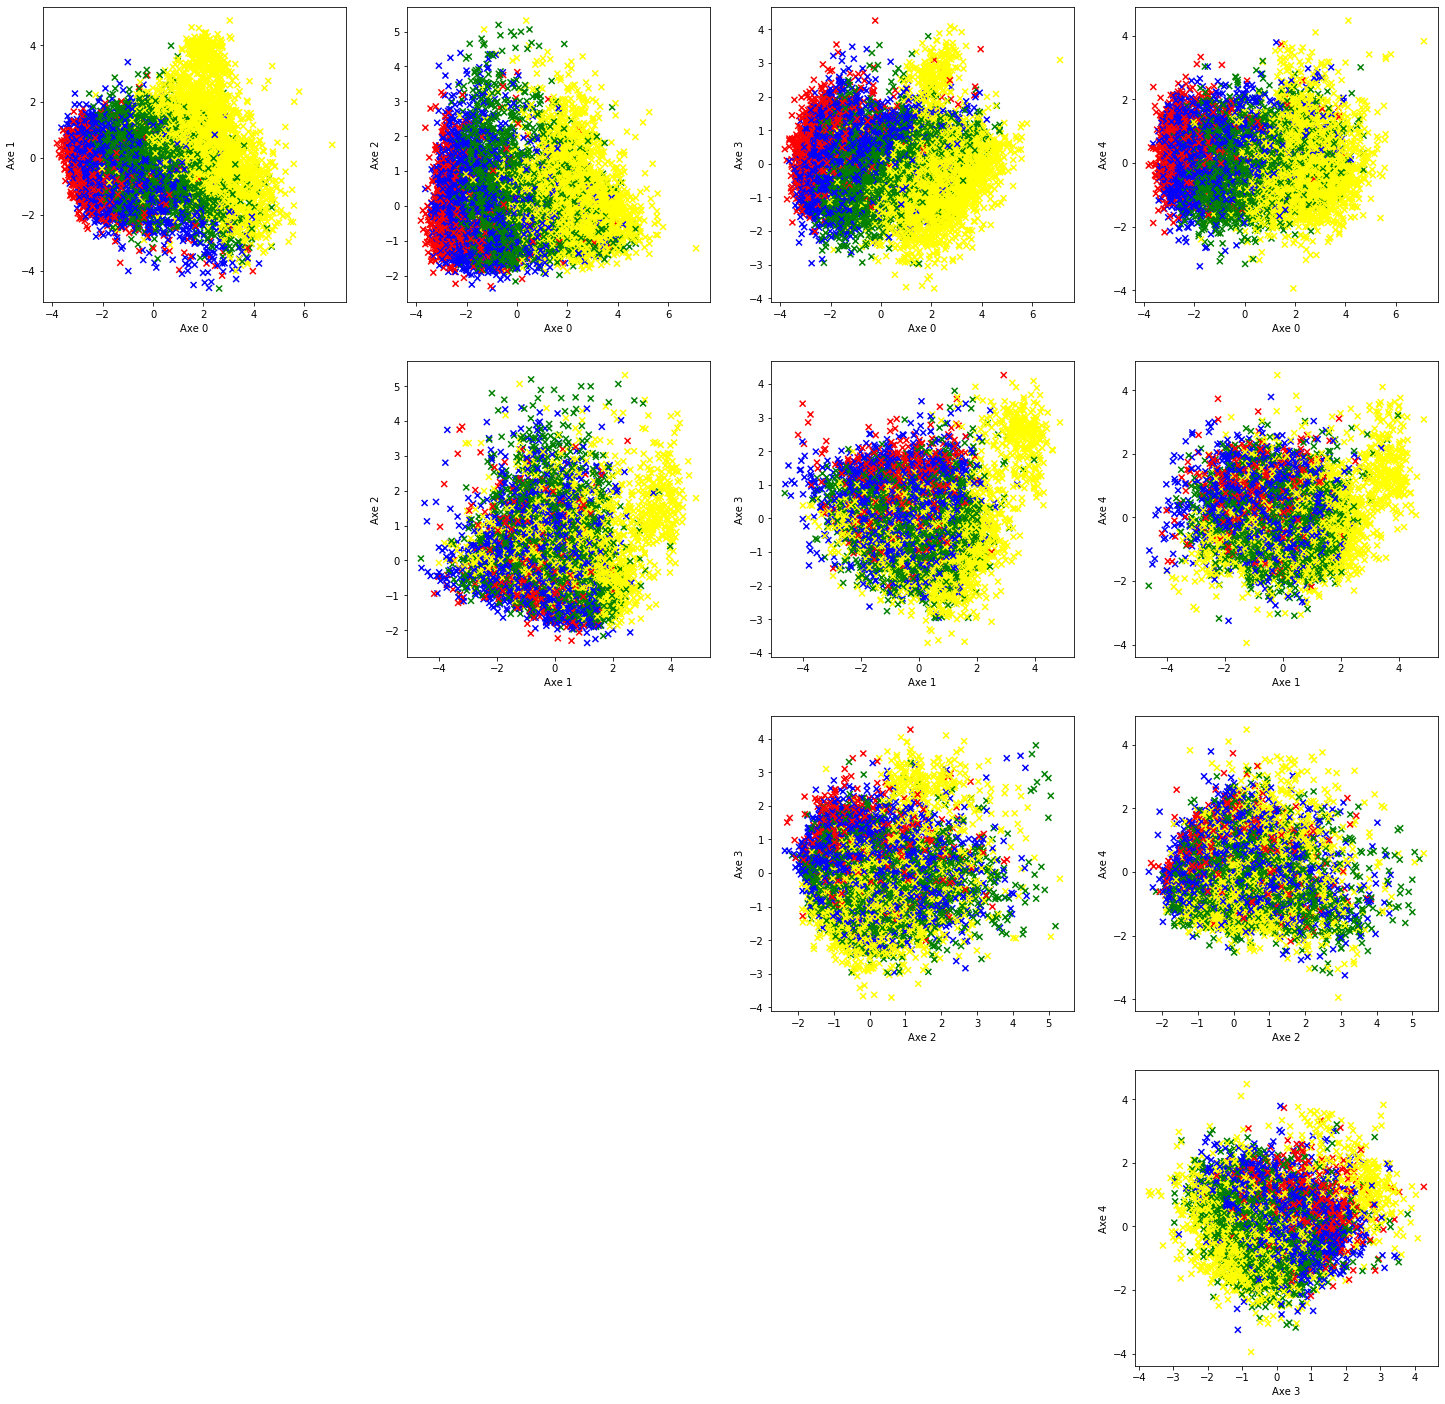

In [26]:
stair_display(individual_graph)

In [27]:
def circle_variable_display(axe_x, axe_y):
    x = pca.components_[axe_x] * np.sqrt(pca.explained_variance_[axe_x])
    y = pca.components_[axe_y] * np.sqrt(pca.explained_variance_[axe_y])
    
    t = np.linspace(0, 2 * np.pi, 100)
    c_x, c_y = np.cos(t), np.sin(t)
    
    for i, j, name in zip(x, y, spotify[quantitativ_variables].columns):
        plt.text(i, j, name)
        plt.arrow(0, 0, i, j)
    plt.plot(c_x, c_y, 'gray')
    plt.axis((-1.2, 1.2, -1.2, 1.2))
    plt.axis('equal')
    plt.xlabel("Axe " + str(axe_x))
    plt.ylabel("Axe " + str(axe_y))

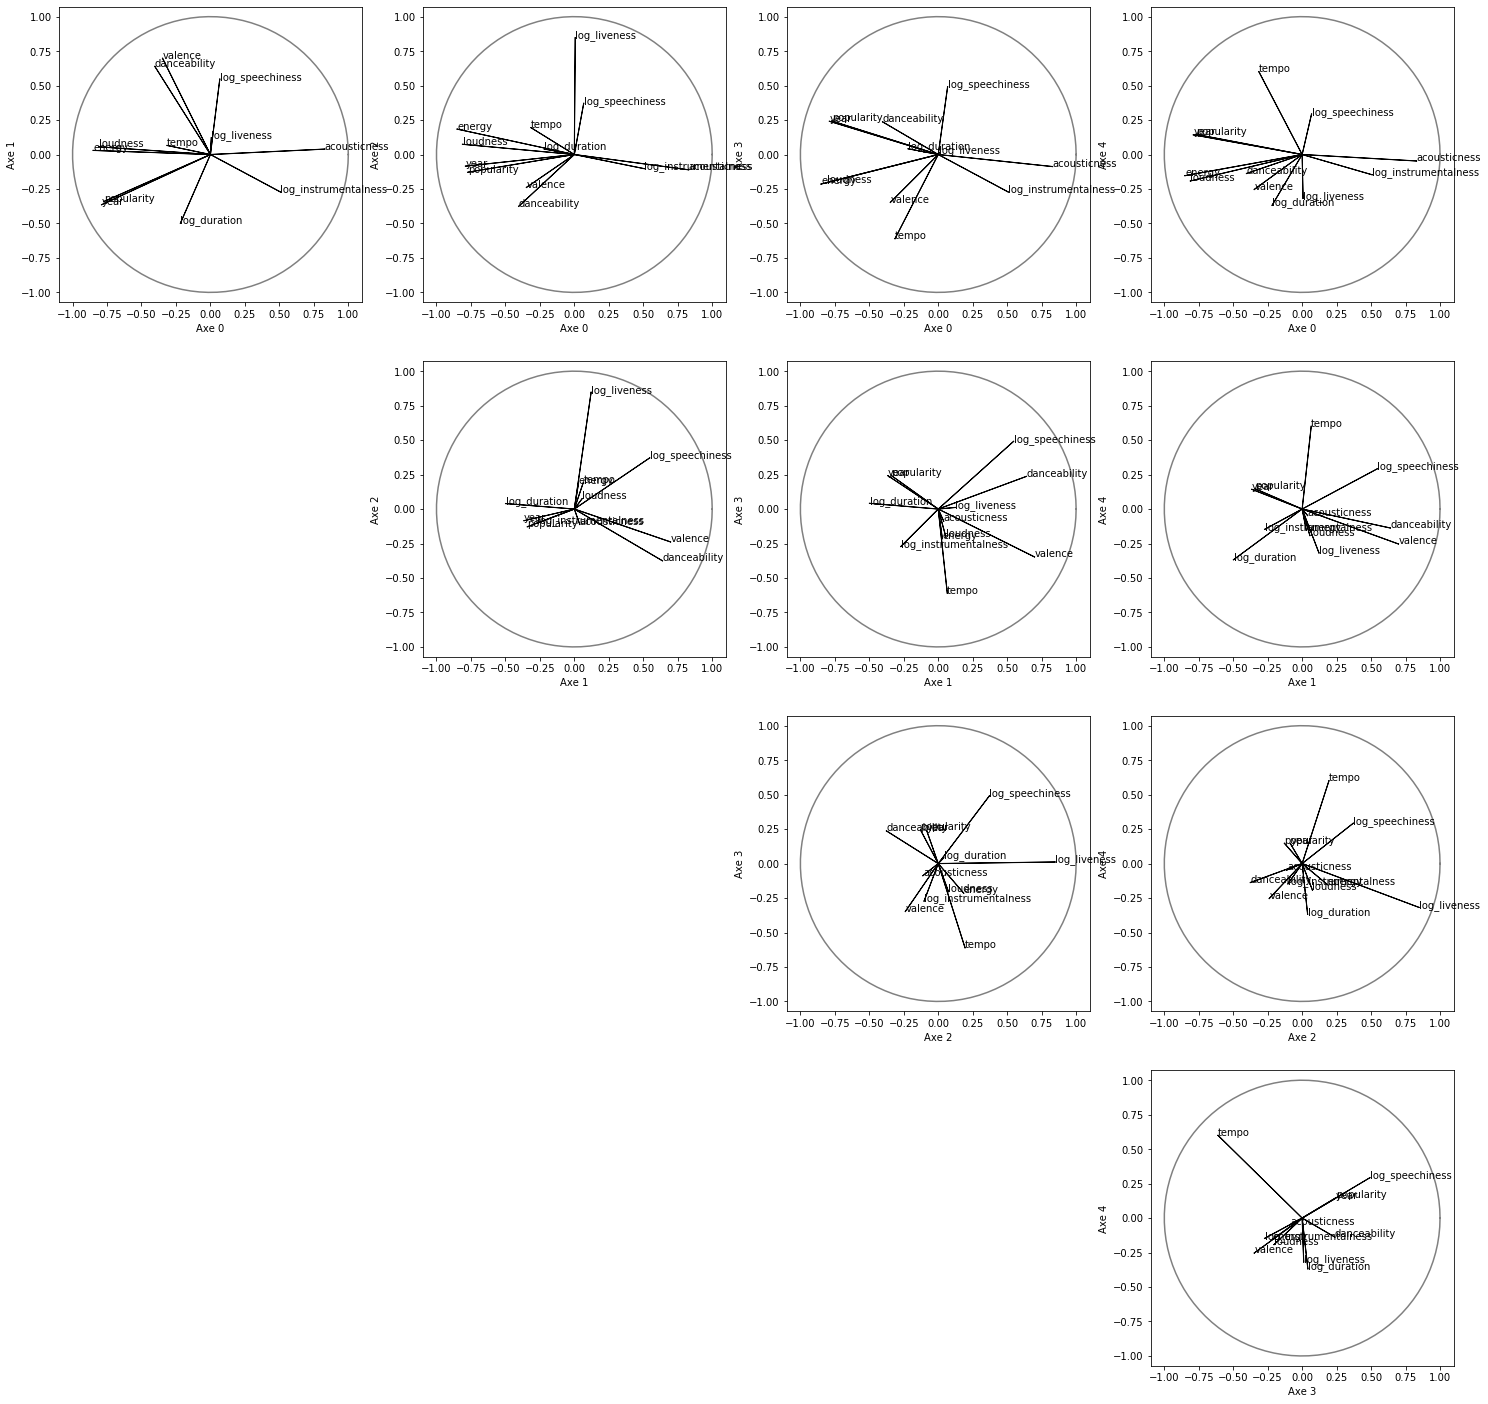

In [28]:
stair_display(circle_variable_display)

## Modélisation

In [29]:
y_reg = spotify["popularity"]
y_class = spotify["pop.class"]

In [30]:
spotify_dum = pd.get_dummies(spotify[["mode", "key"]])

del spotify_dum["key_A"]
del spotify_dum["mode_0"]

spotify_quant = spotify[["valence", "year", "acousticness", "danceability", "energy", "loudness",
                         "tempo", "log_duration", "log_instrumentalness", "log_liveness", "log_speechiness"]]

dfc = pd.concat([spotify_dum, spotify_quant], axis = 1)
dfc.head()

mode_1  key_Ab  key_B  key_Bb  key_C  key_D  key_Db  key_E  key_Eb  \
161704       1       0      1       0      0      0       0      0       0   
168077       1       1      0       0      0      0       0      0       0   
35922        0       0      1       0      0      0       0      0       0   
135823       1       0      1       0      0      0       0      0       0   
165395       0       0      0       0      0      0       0      0       0   

        key_F  ...  year  acousticness  danceability  energy  loudness  \
161704      0  ...  1975        0.4490         0.376   0.827    -7.604   
168077      0  ...  2008        0.8990         0.508   0.169   -11.332   
35922       0  ...  2007        0.0185         0.470   0.878    -5.576   
135823      0  ...  1995        0.0384         0.176   0.980    -3.154   
165395      0  ...  1994        0.5310         0.705   0.625   -11.963   

          tempo  log_duration  log_instrumentalness  log_liveness  \
161704  170.475     12.607664              0.007849      0.382538   
168077  107.477     12.374971              0.000011      0.127513   
35922   150.093     12.615174              0.080566      0.243730   
135823  172.566     11.864990              0.439544      0.212689   
165395   97.831     12.143133              0.000008      0.298622   

        log_speechiness  
161704         0.335758  
168077         0.053825  
35922          0.037007  
135823         0.069619  
165395         0.061941  

[5 rows x 23 columns]

In [52]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(dfc, y_reg, test_size = 2000)
x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(dfc, y_class, test_size = 2000)

In [32]:
def normalization(x_train, x_test):
    scaler = StandardScaler()  
    scaler.fit(x_train)  
    return scaler.transform(x_train), scaler.transform(x_test)

In [53]:
xn_train_reg, xn_test_reg = normalization(x_train_reg, x_test_reg)
xn_train_class, xn_test_class = normalization(x_train_class, x_test_class)

In [35]:
def residuals_display(predicted, observed):
    plt.figure()
    plt.plot(predicted, observed - predicted, "x")
    plt.xlabel("Popularité prédite")
    plt.ylabel("Résidus")
    plt.show()

#### Régression linéaire

In [54]:
param = [{"alpha": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]}]
reg_lasso = GridSearchCV(linear_model.Lasso(), param, cv = 5, n_jobs = -1)
reg_lasso_opt = reg_lasso.fit(xn_train_reg, y_train_reg)
reg_lasso_opt.best_params_["alpha"]
print("Meilleur R2 = ", reg_lasso_opt.best_score_)
print("Meilleur paramètre = ", reg_lasso_opt.best_params_)

Meilleur R2 =  0.7436898209286977
Meilleur paramètre =  {'alpha': 0.1}


#### Arbres

In [ ]:

# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(x_n_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

In [ ]:
y_chap = treeOpt.predict(x_n_test)
# matrice de confusion
table=pd.crosstab(y_chap,y_test)
print(table) hh

## <FONT COLOR="Red">Classification </font>
#### SVM

In [66]:
def pop_class_svm(kernel):
    param = [{"C": [0.2,0.3,0.4,0.6,0.8,1.2],"gamma":[0.03,0.1,0.2,0.3]}]
    svm = GridSearchCV(SVC(kernel = kernel), param, cv = 10, n_jobs = -1)
    svm_opt = svm.fit(xn_train_class, y_train_class)
    prediction = svm_opt.predict(xn_test_class)
    print("Meilleur score : ", 1 - svm_opt.best_score_)
    print("Meilleur paramètre : ", svm_opt.best_params_)
    print("Erreur de prévision sur le test : ", 1 - svm_opt.score(xn_test_class, y_test_class))
    return pd.DataFrame(confusion_matrix(prediction,y_test_class),index=['A', 'B', 'C', 'D'],columns=['A', 'B', 'C' , 'D'])

In [67]:
pop_class_svm('linear')

Meilleur score :  0.29962500000000003
Meilleur paramètre :  {'C': 0.3, 'gamma': 0.03}
Erreur de prévision sur le test :  0.28049999999999997


A    B    C    D
A    0    0    0    0
B  168  427   80   14
C   18  137  423   47
D    1   13   83  589

In [83]:
pop_class_svm('poly')

Meilleur score :  0.3265
Meilleur paramètre :  {'C': 0.2, 'gamma': 0.1}
Erreur de prévision sur le test :  0.3105


A    B    C    D
A   31   22    4    1
B  134  376   87   16
C   20  168  411   72
D    2   11   84  561

In [84]:
pop_class_svm('sigmoid')

Meilleur score :  0.3087500000000001
Meilleur paramètre :  {'C': 0.2, 'gamma': 0.03}
Erreur de prévision sur le test :  0.2945


A    B    C    D
A    0    0    0    0
B  168  426   86   14
C   18  134  397   48
D    1   17  103  588

In [85]:
pop_class_svm('rbf')

Meilleur score :  0.30774999999999997
Meilleur paramètre :  {'C': 1.2, 'gamma': 0.03}
Erreur de prévision sur le test :  0.2845


A    B    C    D
A    5    0    0    0
B  160  412   80   15
C   21  154  423   44
D    1   11   83  591

#### Arbre binaire 

In [69]:
param = [{"max_depth":list(range(2,10))}]
tree = GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOpt = tree.fit(xn_train_class, y_train_class)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))
print("Erreur de prévision =",1-treeOpt.score(xn_test_class,y_test_class))
prediction = treeOpt.predict(xn_test_class)
table = pd.crosstab(prediction,y_test_class)
pd.DataFrame(confusion_matrix(prediction,y_test_class),index=['A', 'B', 'C', 'D'],columns=['A', 'B', 'C' , 'D'])

Meilleur score = 0.267375, Meilleur paramètre = {'max_depth': 3}
Erreur de prévision = 0.251


A    B    C    D
A  78   21    0    8
B  91  415   98    7
C  17  129  417   47
D   1   12   71  588

#### Neural network

In [71]:
param_grid  = [{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}]
net = GridSearchCV(MLPClassifier(max_iter=500),param_grid,cv = 10, n_jobs=-1)
netOpti = net.fit(xn_train_class,y_train_class)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - netOpti.best_score_,netOpti.best_params_))
print("Estimation de l'erreur de prévision sur le test =",1-netOpti.score(xn_test_class,y_test_class))
prediction = netOpti.predict(xn_test_class)
pd.DataFrame(confusion_matrix(prediction,y_test_class),index=['A', 'B', 'C', 'D'],columns=['A', 'B', 'C' , 'D'])

Meilleur score = 0.273625, Meilleur paramètre = {'hidden_layer_sizes': (7,)}
Estimation de l'erreur de prévision sur le test = 0.259


A    B    C    D
A  65   24    0    4
B  99  381   63    8
C  22  161  452   54
D   1   11   71  584

#### Forêt aléatoire

In [73]:
param = [{"max_features":list(range(2,10,1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt = rf.fit(xn_train_class, y_train_class)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))
print("Erreur de prévision sur le test =",1-rfOpt.score(xn_test_class,y_test_class))
prediction = rfOpt.predict(xn_test_class)
pd.DataFrame(confusion_matrix(prediction,y_test_class),index=['A', 'B', 'C', 'D'],columns=['A', 'B', 'C' , 'D'])

Meilleur score = 0.266625, Meilleur paramètre = {'max_features': 7}
Erreur de prévision sur le test = 0.257


A    B    C    D
A  69   13    1    7
B  94  392   77    8
C  22  160  442   52
D   2   12   66  583

#### Régression logistique

In [77]:
param = [{"C": [1, 1.2, 1.5, 1.7, 2, 3, 4]}]
logit = GridSearchCV(LogisticRegression(penalty = "l1", solver = "liblinear"), param, cv = 5, n_jobs = -1)
logit_opt = logit.fit(xn_train_class, y_train_class)
logit_opt.best_params_["C"]
print("Meilleur score =", 1.-logit_opt.best_score_)
print("Meilleur paramètre =", logit_opt.best_params_)
print("Erreur de prévision sur le test =",1-logit_opt.score(xn_test_class,y_test_class))
prediction = logit_opt.predict(xn_test_class)
pd.DataFrame(confusion_matrix(prediction,y_test_class),index=['A', 'B', 'C', 'D'],columns=['A', 'B', 'C' , 'D'])

Meilleur score = 0.3244999999999999
Meilleur paramètre = {'C': 4}
Erreur de prévision sur le test = 0.3065


A    B    C    D
A    8    0    0    0
B  158  430  114   15
C   19  125  342   28
D    2   22  130  607

Lasso conserve 23 variables et en supprime 0


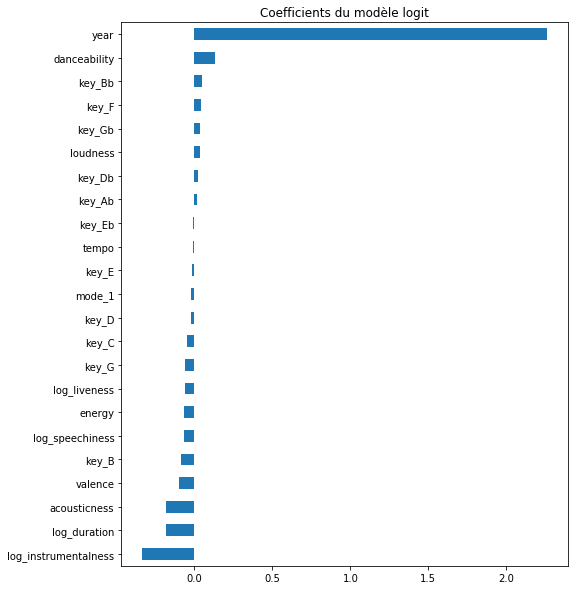

In [82]:
logit_lasso = LogisticRegression(penalty = "l1", C = logit_opt.best_params_['C'], solver = "liblinear")
logit_coef = logit_lasso.fit(xn_train_class, y_train_class).coef_
coef = pd.Series(logit_coef[0], index = x_train_class.columns)
print("Lasso conserve", str(sum(coef != 0)), "variables et en supprime", str(sum(coef == 0)))
imp_coef = coef.sort_values()
plt.figure()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients du modèle logit")
plt.show()

In [57]:
probas_ = LogisticRegression(penalty = "l1",
                             solver = "liblinear",
                             C = logit_opt.best_params_['C']).fit(x_train_class, y_train_class).predict_proba(x_test_class)
fpr, tpr, thresholds = roc_curve(y_test_class, probas_[:, 1])

plt.figure()
plt.plot(fpr, tpr, lw = 1)
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.show()

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


ValueError: multiclass format is not supported

## <FONT COLOR="Red">Regression </font>
#### SVM

In [91]:
def popularity_svm(kernel):
    param = [{"C": [0.2,0.3,0.4,0.6,0.8,1.2],"gamma":[0.03,0.1,0.2,0.3]}]
    svm = GridSearchCV(SVR(kernel = kernel), param, cv = 10, n_jobs = -1)
    svm_opt = svm.fit(xn_train_reg, y_train_reg)
    prediction = svm_opt.predict(xn_test_reg)
    print("Meilleur score : ", 1 - svm_opt.best_score_)
    print("Meilleur paramètre : ", svm_opt.best_params_)
    print("Erreur de prévision sur le test : ", 1 - svm_opt.score(xn_test_reg, y_test_reg))
    MSE = mean_squared_error(prediction,y_test_reg)
    residuals = y_test_reg-prediction
    r2 = r2_score(prediction,y_test_reg)
    print("MSE=",MSE)
    print("R2=",r2)

In [92]:
popularity_svm('linear')

Meilleur score :  0.2631857291018853
Meilleur paramètre :  {'C': 0.2, 'gamma': 0.03}
Erreur de prévision sur le test :  0.2454367976456211
MSE= 119.92711582723744
R2= 0.6894766238996567


In [93]:
popularity_svm('poly')

Meilleur score :  0.2985767322740951
Meilleur paramètre :  {'C': 0.3, 'gamma': 0.2}
Erreur de prévision sur le test :  0.27627816538005423
MSE= 134.99704957815877
R2= 0.6557334774727739


In [94]:
popularity_svm('rbf')

Meilleur score :  0.2700644395970162
Meilleur paramètre :  {'C': 1.2, 'gamma': 0.03}
Erreur de prévision sur le test :  0.2550285355217614
MSE= 124.61390065449584
R2= 0.6375732085482491


#### Neural network

In [95]:
param_grid  = [{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}]
net = GridSearchCV(MLPRegressor(max_iter=500),param_grid,cv = 10, n_jobs=-1)
netOpti = net.fit(xn_train_reg,y_train_reg)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - netOpti.best_score_,netOpti.best_params_))
print("Estimation de l'erreur de prévision sur le test =",1-netOpti.score(xn_test_reg,y_test_reg))
prediction = netOpti.predict(xn_test_reg)
MSE = mean_squared_error(prediction,y_test_reg)
residuals = y_test_reg-prediction
r2 = r2_score(prediction,y_test_reg)
print("MSE=",MSE)
print("R2=",r2)

Meilleur score = 0.246296, Meilleur paramètre = {'hidden_layer_sizes': (8,)}
Estimation de l'erreur de prévision sur le test = 0.23259507695221726
MSE= 113.65230072293292
R2= 0.697292467007071


C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### Arbre binaire

In [96]:
param = [{"max_depth":list(range(2,10))}]
tree = GridSearchCV(DecisionTreeRegressor()),param,cv=10,n_jobs=-1)
treeOpt = tree.fit(xn_train_reg, y_train_reg)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))
print("Erreur de prévision =",1-treeOpt.score(xn_test_reg,y_test_reg))
prediction = treeOpt.predict(xn_test_reg)
MSE = mean_squared_error(prediction,y_test_reg)
residuals = y_test_reg-prediction
r2 = r2_score(prediction,y_test_reg)
print("MSE=",MSE)
print("R2=",r2)

SyntaxError: invalid syntax (<ipython-input-96-2bd00322f431>, line 2)

#### Forêt aléatoire

In [ ]:
param = [{"max_features":list(range(2,10,1))}]
rf = GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt = rf.fit(xn_train_reg, y_train_reg)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))
print("Erreur de prévision sur le test =",1-rfOpt.score(xn_test_reg,y_test_reg))
prediction = rfOpt.predict(xn_test_reg)
MSE = mean_squared_error(prediction,y_test_reg)
residuals = y_test_reg-prediction
r2 = r2_score(prediction,y_test_reg)
print("MSE=",MSE)
print("R2=",r2)

#### Regression linéaire

In [55]:
prev = reg_lasso_opt.predict(xn_test_reg)
print("MSE = ", mean_squared_error(y_test_reg, prev))
print("R2 = ", r2_score(y_test_reg, prev))

MSE =  116.8205411086827
R2 =  0.7609209617760873


Lasso conserve 13 variables et en supprime 10


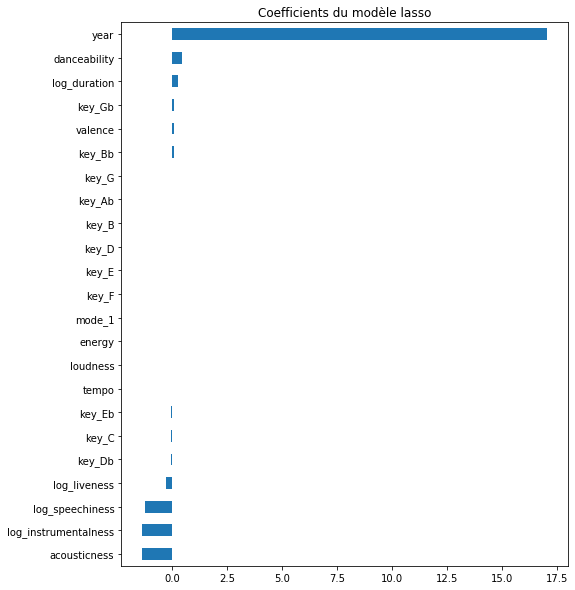

In [57]:
reg_lasso = linear_model.Lasso(alpha = reg_lasso_opt.best_params_['alpha'])
model_lasso = reg_lasso.fit(xn_train_reg, y_train_reg)
model_lasso.coef_
coef = pd.Series(model_lasso.coef_, index = x_train_reg.columns)
print("Lasso conserve", str(sum(coef != 0)), "variables et en supprime", str(sum(coef == 0)))
imp_coef = coef.sort_values()

plt.figure()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients du modèle lasso")
plt.show()

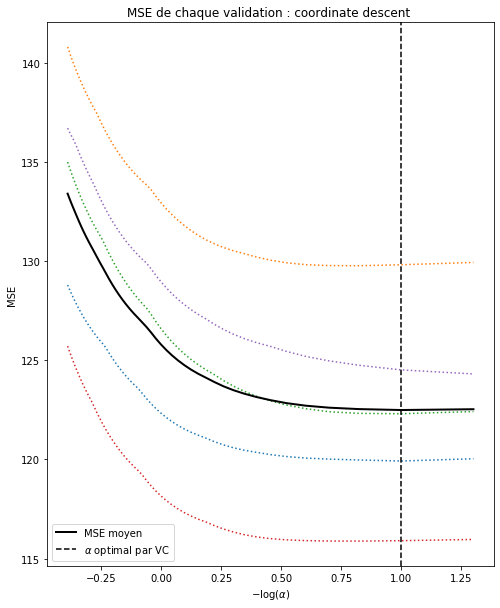

In [59]:
model = LassoCV(cv = 5, alphas = np.array(range(1, 50, 1)) / 20., n_jobs = -1, random_state = 13).fit(xn_train_reg, y_train_reg)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k', label = 'MSE moyen', linewidth = 2)
plt.axvline(-np.log10(model.alpha_), linestyle = '--', color = 'k', label = '$\\alpha$ optimal par VC')
plt.legend()
plt.xlabel('$-\log(\\alpha)$')
plt.ylabel('MSE')
plt.title('MSE de chaque validation : coordinate descent ')
plt.show()

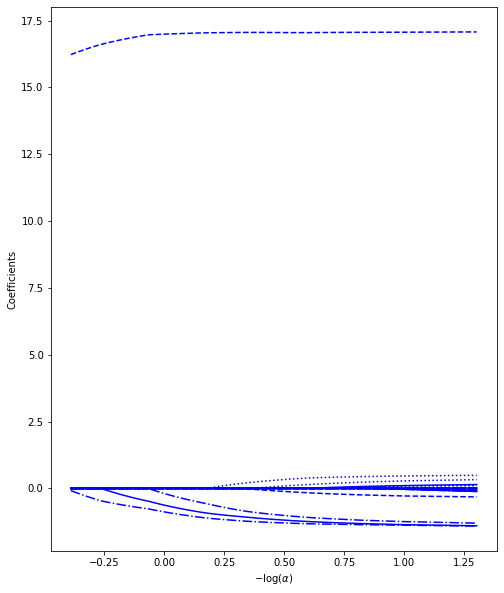

In [60]:
alphas_lasso, coefs_lasso, _ = lasso_path(xn_train_reg, y_train_reg, alphas = np.arange(1, 50) / 20.)

plt.figure()
ax = plt.gca()
styles = cycle(['-', '--', '-.', ':'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, s in zip(coefs_lasso, styles):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle = s, c = 'b')
plt.xlabel('$-\log(\\alpha)$')
plt.ylabel('Coefficients')
plt.show()
